# Attention & Transformers
<small><small>(With thanks to Sharique Pervaiz for helping prepare this worksheet.)</small></small>

 In this worksheet you will implement the original transofmer architecture in the seminal ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) paper twith Keras. The original application was on language translation, so we will use sample data from Portuguese to English.
 Note that training such data takes a very long time, so we will also show how to employ pre-trained models at the end. Training such a transformer language model takes a long time, so we will also show how to employ pre-trained models from [Hugging Face](https://huggingface.co/).

 Note:  to avoid library dependency issues, you can run this worksheet on Google Colab.

#### Loading the data

We use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import keras_nlp

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.3KXNUL_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.3KXNUL_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.3KXNUL_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [2]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Tokenize the data

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses the tokenizers built in the [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) tutorial. That tutorial optimizes two `text.BertTokenizer` objects (one for English, one for Portuguese) for **this dataset** and exports them in a TensorFlow `saved_model` format.

> Note: This is different from the [original paper](https://arxiv.org/pdf/1706.03762.pdf), section 5.1, where they used a single byte-pair tokenizer for both the source and target with a vocabulary-size of 37000.

Download, extract, and import the `saved_model`:

In [4]:
import os

model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

tokenizers = tf.saved_model.load(f"/content/{model_name}_extracted/{model_name}")


184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [5]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))
  break
print()
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)
  break
print()

print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
print(tokens[0])
print()

round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))
  break


> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]

> This is the text split into tokens:
tf.Tensor(
[b'[START]' b'and' b'when' b'you' b'improve' b'search' b'##ability' b','
 b'you' b'actually' b'take' b'away' b'the' b'one' b'advantage' b'of'
 b'print' b',' b'which' b'is' b's' b'##ere' b'##nd' b'##ip' b'##ity' b'.'
 b'[END]'], shape=(27,), dtype=string)

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [6]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training.

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples.
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [8]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Building the model

### Positional Embedding

The original paper uses the following formula for calculating the positional encoding:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

We will make a layer which will combine the embedding layer with adding positional encodings as well

In [9]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, LayerNormalization, TimeDistributed, Add
from tensorflow.keras import Model, Input

class SineCosinePositionalEmbedding(tf.keras.layers.Layer):
    """
    Implements the sine/cosine positional encoding described in the "Attention is All You Need" paper.
    This is a non-trainable embedding that uses sin and cos functions of different frequencies.
    """
    def __init__(self, vocab_size, maxlen, d_model):
        super().__init__()
        self.max_len = maxlen
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)


        # Create the positional embedding matrix using numpy
        pos = np.arange(self.max_len)[:, np.newaxis]     # shape (max_len, 1)
        i = np.arange(self.d_model)[np.newaxis, :]       # shape (1, d_model)

        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.d_model))

        angle_rads = pos * angle_rates


        # apply sin to even indices: 2i
        sines = np.sin(angle_rads[:, 0::2])
        # apply cos to odd indices: 2i+1
        cosines = np.cos(angle_rads[:, 1::2])

        # merge sines and cosines
        pos_encoding = np.zeros((self.max_len, self.d_model))
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        # Convert to a TF constant
        self.pos_encoding = tf.constant(pos_encoding, shape=(self.max_len, self.d_model), dtype=tf.float32)

    def call(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        # Add the positional encoding up to seq_len
        # pos_encoding shape: (max_len, d_model)
        x = x + self.pos_encoding[:seq_len, :]
        return x



### Encoder block

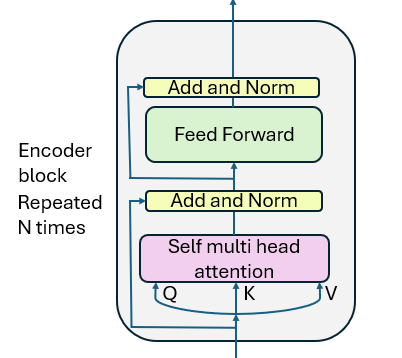

In [10]:
# Define the TransformerBlock (Encoder block)
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model),
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.add1 = Add()
        self.add2 = Add()
        self.dropout = Dropout(rate)

    def call(self, inputs):
        # Self-attention
        attn_output = self.att(query=inputs, key=inputs, value=inputs)
        norm_input_1 = self.add1([inputs, attn_output])
        out1 = self.layernorm1(norm_input_1)

        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)

        norm_input_2 = self.add2([out1, ffn_output])
        out = self.layernorm2(norm_input_2)

        return out

## Decoder block

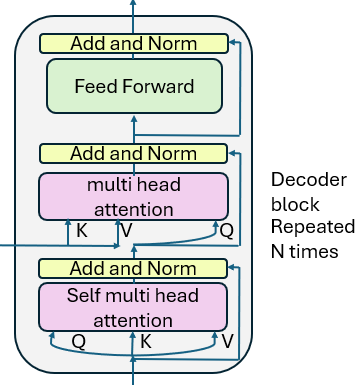

In [12]:
# Define the TransformerBlock (Decoder block)
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.layernorm3 = LayerNormalization()
        self.add1 = Add()
        self.add2 = Add()
        self.add3 = Add()
        self.dropout = Dropout(rate)

    def call(self, inputs, context):

        # Self-attention
        attn_output = self.att1(query=inputs, key=inputs, value=inputs, use_causal_mask = True)
        norm_input_1 = self.add1([inputs, attn_output])
        out1 = self.layernorm1(norm_input_1)

        # Cross-attention
        attn_output = self.att1(query=inputs, key=context, value=context)
        norm_input_1 = self.add2([inputs, attn_output])
        out1 = self.layernorm1(norm_input_1)

        # Feed-forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)

        norm_input_2 = self.add3([out1, ffn_output])
        out = self.layernorm2(norm_input_2)

        return out

### Putting it all together
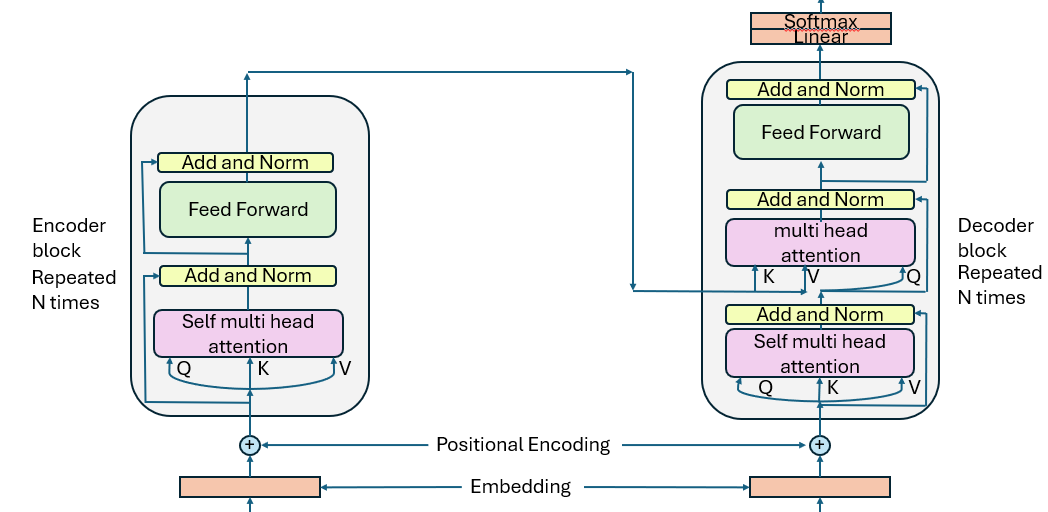

In [13]:
# Build the Transformer NER model
input_vocab_size = tokenizers.pt.get_vocab_size().numpy()
target_vocab_size = tokenizers.en.get_vocab_size().numpy()
num_layers = 2
d_model = 128
dff = 256
num_heads = 4
dropout_rate = 0.1
maxlen = MAX_TOKENS

# Define the input
encoder_inputs = Input(shape=(None,), name='portugese_input_tokens')
decoder_inputs = Input(shape=(None,), name='english_input_tokens')

# Embedding and positional encoding
context = SineCosinePositionalEmbedding(input_vocab_size,maxlen, d_model)(encoder_inputs)

x = SineCosinePositionalEmbedding(target_vocab_size,maxlen, d_model)(decoder_inputs)

for _ in range(num_layers):
    context = EncoderBlock(d_model, num_heads, dff, dropout_rate)(context)

for _ in range(num_layers):
    x = DecoderBlock(d_model, num_heads, dff, dropout_rate)(x, context)

# Final layer: TimeDistributed dense for token-level classification
outputs = Dense(target_vocab_size)(x)

model = Model(inputs=[encoder_inputs,decoder_inputs], outputs=outputs)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'decoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'decoder_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [14]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [15]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

**Note: This takes a couple of hours to train in Colab.**

In [28]:
model.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ portugese_input_tokens    │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sine_cosine_positional_e… │ (None, None, 128)      │        993,920 │ portugese_input_token… │
│ (SineCosinePositionalEmb… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ english_input_tokens      │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block             │ (None, None, 128)      │        330,240 │ sine_cosine_positiona… │
│ (EncoderBlock)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sine_cosine_positional_e… │ (None, None, 128)      │        897,280 │ english_input_tokens[… │
│ (SineCosinePositionalEmb… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_block_1           │ (None, None, 128)      │        330,240 │ encoder_block[0][0]    │
│ (EncoderBlock)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block             │ (None, None, 128)      │        330,240 │ sine_cosine_positiona… │
│ (DecoderBlock)            │                        │                │ encoder_block_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_block_1           │ (None, None, 128)      │        330,240 │ decoder_block[0][0],   │
│ (DecoderBlock)            │                        │                │ encoder_block_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, None, 7010)     │        904,290 │ decoder_block_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,349,351 (47.11 MB)

 Trainable params: 4,116,450 (15.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,232,901 (31.41 MB)

In [30]:
# model.fit(train_batches, epochs=20, validation_data=val_batches) # This takes a couple of hours in Colab

KeyboardInterrupt: 

## Using a Pretrained Model
Alternatively, you can load a pre-trained translation model from Hugging Face and use it very easily. One such good translation model can be found here:
[facebook/mbart-large-50-many-to-many-mmt](https://huggingface.co/facebook/mbart-large-50-many-to-many-mmt)

Read the documentation to learn more about the usage of the model

Here are the steps of using model from the Hugging Face library
1. Get the name of the model from the Hugging Face repository card.
2. Click on `use this model` and then `transformers` to get the code of loading model and tokenizer.
3. Use the code to download tokenizer and model
4. Tokenize the text using the tokenizer.
5. Pass the output from tokenizer to model using  `generate()` function.
6. Detokenize the output from the model using the tokenizer using `batch_decode() function`
7. Print the detokenized output

In [31]:
# Load model directly
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

hf_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
hf_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", src_lang="pt_XX", tgt_lang="en_XX")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

Here are the steps of using the pre-trained model from Hugging Face:


In [32]:
def translate(sentence):

  tokens = hf_tokenizer(sentence, return_tensors="pt")
  translation = hf_model.generate(**tokens)
  translation = hf_tokenizer.batch_decode(translation, skip_special_tokens=True)[0]
  return translation

def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [33]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text = translate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : este é um problema que temos que resolver.
Prediction     : This is a problem we have to solve.
Ground truth   : this is a problem we have to solve .


In [34]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text = translate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : os meus vizinhos ouviram sobre esta ideia.
Prediction     : My neighbors heard about this idea.
Ground truth   : and my neighboring homes heard about this idea .


In [35]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text = translate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : So I'm going to very quickly share with you some stories of some magical things that happened.
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.
